In [1]:
import pandas as pd
import numpy as np
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed,GRU, Conv1D

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# 총발전, 총소비 데이터 추출

In [2]:
df1 = pd.read_csv('./211104/211104 dashboard_time_series_chart.csv', parse_dates = True)

In [3]:
df1['DateTime']= pd.to_datetime(df1['DateTime'])

In [4]:
df1=df1[(df1['DateTime']>='2021-09-13 00:00:00')]

In [5]:
df1=df1[(df1['DateTime']<'2021-11-04 00:00:00')]

In [6]:
df1

,DateTime,energyTotalProduce,energyTotalConsume,ToESS(We),ESSout(We),energyTotalSelfConsumeRate,energyTotalSelfRate,SCF,LCF,SCF_acc,LCF_acc
20469,2021-09-13 00:00:00,9.869,6694.41,118.000,0.0,1.0,0.240607,0.0,0.000000,0,0.000000
20470,2021-09-13 00:03:00,9.334,6440.19,112.667,0.0,1.0,0.240602,0.0,0.000000,0,0.000000
20471,2021-09-13 00:06:00,9.667,5711.75,112.333,0.0,1.0,0.240589,0.0,0.000000,0,0.000000
20472,2021-09-13 00:07:00,9.464,5851.42,112.643,0.0,1.0,0.240584,0.0,0.000000,0,0.000000
20473,2021-09-13 00:08:00,9.766,6590.12,112.310,0.0,1.0,0.240579,0.0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
77303,2021-11-03 23:55:00,569.283,7573.30,0.000,0.0,1.0,0.714178,1.0,0.075170,1,0.366645
77304,2021-11-03 23:56:00,567.933,7719.92,0.000,0.0,1.0,0.714173,1.0,0.073567,1,0.366642
77305,2021-11-03 23:57:00,567.933,7962.67,0.000,0.0,1.0,0.714168,1.0,0.071324,1,0.366640
77306,2021-11-03 23:58:00,569.500,8019.32,0.000,0.0,1.0,0.714162,1.0,0.071016,1,0.366638


# ESS충방전량 추출

In [7]:
df2 = pd.read_csv('./211104/211104 kepsh1.csv', parse_dates = True)

In [8]:
df2['DateTime']= pd.to_datetime(df2['DateTime'])

In [9]:
df2=df2[(df2['DateTime']>='2021-09-13 00:00:00')]

In [10]:
df2=df2[(df2['DateTime']<'2021-11-04 00:00:00')]

In [11]:
df2

,DateTime,Room_Temp(�C),T1(�C),T2(�C),T3(�C),T4(�C),T5(�C),T6(�C),T8(�C),T9(�C),...,Pvt_Supply(W),Pv_Supply(W),Heatpump_Load(W),FuelCell_Supply(W),WS_Temperature(�C),WS_SolarRadiation(w/m�),WS_WindDirection_Slope(w/m�),Thermal_Operation_Mode,Total_Consumption(W),Total_Production(W)
158524,2021-09-13 00:00:00,26.5,38.975,36.197,25.940,23.875,27.271,100.000,25.158,45.849,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,677,9
158525,2021-09-13 00:03:00,26.5,38.988,36.235,26.104,24.017,27.390,100.000,25.140,45.847,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,674,9
158526,2021-09-13 00:04:00,26.5,38.972,36.238,26.165,24.061,27.433,100.000,25.146,45.857,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,780,9
158527,2021-09-13 00:05:00,26.5,38.966,36.220,26.222,24.125,27.480,100.000,25.128,45.843,...,9.0,-49.0,28.0,0.0,22.0,0.0,0.0,0.0,806,9
158528,2021-09-13 00:06:00,26.5,38.980,36.217,26.281,24.180,27.529,100.000,25.160,45.854,...,9.0,-49.0,29.0,0.0,22.0,0.0,0.0,0.0,797,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223885,2021-11-03 23:55:00,26.1,33.109,33.380,31.618,30.754,31.927,30.845,19.279,53.002,...,-9.0,-50.0,29.0,569.0,17.0,13.4,0.0,0.0,892,569
223886,2021-11-03 23:56:00,26.1,33.110,33.381,31.586,30.731,31.907,30.812,19.283,53.003,...,-9.0,-50.0,29.0,568.0,17.0,13.4,0.0,0.0,896,568
223887,2021-11-03 23:57:00,26.1,33.108,33.378,31.565,30.708,31.888,30.785,19.282,52.997,...,-9.0,-50.0,29.0,568.0,17.0,13.4,0.0,0.0,897,568
223888,2021-11-03 23:58:00,26.1,33.106,33.372,31.538,30.685,31.866,30.763,19.277,52.989,...,-9.0,-50.0,29.0,570.0,17.0,13.4,0.0,0.0,892,570


# ToGrid 데이터 추출

In [12]:
df3 = pd.read_csv('./211104/211104 dashboard_facility_enegy_flow.csv', parse_dates = True)

In [13]:
df3['DateTime']= pd.to_datetime(df3['DateTime'])

In [14]:
df3=df3[(df3['DateTime']>='2021-09-13 00:00:00')]

In [15]:
df3=df3[(df3['DateTime']<'2021-11-04 00:00:00')]

In [16]:
df3

,DateTime,PVout(We),PVTout(We),FCout(We),PlugLoad(We),LightLoad(We),FromGrid(We),ToGrid(We),ToESS(We),ESSout(We),...,GSHP2HTES(Wt),ASHP2Cool(Wt),ASHP2Heat(Wt),CTES2Cool(Wt),HTES2Heat(Wt),HTES2Water(Wt),DirectElec(We),CoolLoad(Wt),HeatLoad(Wt),HotwaterLoad(Wt)
3115,2021-09-13 00:04:00,-80.638,9.414,0.000,2626.05,649.629,6360.67,0.0,112.672,0.0,...,0.0,2393.78,0.0,0.00,0.0,0.0,3275.68,2393.78,0.0,0.0
3116,2021-09-13 00:06:00,-78.139,9.667,0.000,2492.71,640.722,5702.08,0.0,112.333,0.0,...,0.0,2436.01,0.0,0.00,0.0,0.0,3133.43,2436.01,0.0,0.0
3117,2021-09-13 00:08:00,-79.959,9.552,0.000,2394.03,641.167,6580.36,0.0,112.310,0.0,...,0.0,2497.65,0.0,0.00,0.0,0.0,3035.20,2497.65,0.0,0.0
3118,2021-09-13 00:10:00,-79.772,9.541,0.000,2417.50,652.340,8362.08,0.0,112.730,0.0,...,0.0,2439.18,0.0,9162.40,0.0,0.0,3069.84,11601.60,0.0,0.0
3119,2021-09-13 00:11:00,-79.579,9.421,0.000,2398.74,690.117,7620.11,0.0,112.474,0.0,...,0.0,2462.05,0.0,5654.57,0.0,0.0,3088.86,8116.63,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57736,2021-11-03 23:55:00,-82.800,-74.267,569.233,6000.10,1339.370,7004.02,0.0,0.000,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,7339.47,0.00,0.0,0.0
57737,2021-11-03 23:56:00,-82.867,-74.600,567.933,6016.00,1470.630,7151.98,0.0,0.000,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,7486.64,0.00,0.0,0.0
57738,2021-11-03 23:57:00,-82.717,-74.600,567.933,5963.23,1765.020,7394.73,0.0,0.000,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,7728.25,0.00,0.0,0.0
57739,2021-11-03 23:58:00,-82.717,-74.400,569.500,6032.48,1751.720,7449.82,0.0,0.000,0.0,...,0.0,0.00,0.0,0.00,0.0,0.0,7784.20,0.00,0.0,0.0


# KPEC 합치기

In [17]:
df_kpec = pd.DataFrame()
df_kpec['Time'] = df2['DateTime']

In [18]:
df_kpec=df_kpec.set_index('Time')
df1=df1.set_index('DateTime')
df2=df2.set_index('DateTime')
df3=df3.set_index('DateTime')

In [19]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS_Power(W)']*(-1)
df_kpec['ToGrid(W)'] = df3['ToGrid(We)']

In [20]:
df_kpec = df_kpec[df_kpec['Cons_kpec(W)']< 40000]

In [21]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 55924 entries, 2021-09-13 00:00:00 to 2021-11-03 23:59:00
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Cons_kpec(W)  55924 non-null  float64
 1   Prod_kpec(W)  55924 non-null  float64
 2   ESS_kpec(W)   55924 non-null  float64
 3   ToGrid(W)     53816 non-null  float64
dtypes: float64(4)
memory usage: 2.1 MB


In [22]:
# df_kpec=df_kpec.resample('5T').mean()

In [23]:
df_kpec=df_kpec.dropna()

In [24]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W)
Time,,,,
2021-09-13 00:06:00,5711.75,9.667,-0.0,0.0
2021-09-13 00:08:00,6590.12,9.766,-0.0,0.0
2021-09-13 00:15:00,8104.46,9.560,-0.0,0.0
2021-09-13 00:18:00,7236.15,9.379,-0.0,0.0
2021-09-13 00:19:00,8711.00,9.200,-0.0,0.0
...,...,...,...,...
2021-11-03 23:55:00,7573.30,569.283,-0.0,0.0
2021-11-03 23:56:00,7719.92,567.933,-0.0,0.0
2021-11-03 23:57:00,7962.67,567.933,-0.0,0.0


In [25]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*5/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*5/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*5/3600

In [26]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(W)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*5/3600

In [27]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [28]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [29]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [30]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [31]:
df_kpec.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 53816 entries, 2021-09-13 00:06:00 to 2021-11-03 23:59:00
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Cons_kpec(W)       53816 non-null  float64
 1   Prod_kpec(W)       53816 non-null  float64
 2   ESS_kpec(W)        53816 non-null  float64
 3   ToGrid(W)          53816 non-null  float64
 4   Cons_acc_kpec(Wh)  53816 non-null  float64
 5   Prod_acc_kpec(Wh)  53816 non-null  float64
 6   ESS_acc_kpec(Wh)   53816 non-null  float64
 7   E_self(W)          53816 non-null  float64
 8   E_self_acc(Wh)     53816 non-null  float64
 9   denominator        53816 non-null  float64
 10  denominator_acc    53816 non-null  float64
 11  SCF                53816 non-null  float64
 12  LCF                53816 non-null  float64
 13  SCF_acc            53816 non-null  float64
 14  LCF_acc            53816 non-null  float64
 15  self_sustain       53816 non-null  

In [32]:
df_kpec

,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W),Cons_acc_kpec(Wh),Prod_acc_kpec(Wh),ESS_acc_kpec(Wh),E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
Time,,,,,,,,,,,,,,,,,
2021-09-13 00:06:00,5711.75,9.667,-0.0,0.0,4.759792e+02,8.055833e-01,-0.00000,9.667,8.055833e-01,9.667,8.055833e-01,1.0,0.001692,1.000000,0.001692,0.001692,0.500846
2021-09-13 00:08:00,6590.12,9.766,-0.0,0.0,1.025156e+03,1.619417e+00,-0.00000,9.766,1.619417e+00,9.766,1.619417e+00,1.0,0.001482,1.000000,0.001580,0.001580,0.500790
2021-09-13 00:15:00,8104.46,9.560,-0.0,0.0,1.700527e+03,2.416083e+00,-0.00000,9.560,2.416083e+00,9.560,2.416083e+00,1.0,0.001180,1.000000,0.001421,0.001421,0.500710
2021-09-13 00:18:00,7236.15,9.379,-0.0,0.0,2.303540e+03,3.197667e+00,-0.00000,9.379,3.197667e+00,9.379,3.197667e+00,1.0,0.001296,1.000000,0.001388,0.001388,0.500694
2021-09-13 00:19:00,8711.00,9.200,-0.0,0.0,3.029457e+03,3.964333e+00,-0.00000,9.200,3.964333e+00,9.200,3.964333e+00,1.0,0.001056,1.000000,0.001309,0.001309,0.500654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-03 23:55:00,7573.30,569.283,-0.0,0.0,4.673096e+07,4.939746e+07,142230.88975,569.283,2.222315e+07,569.283,2.222315e+07,1.0,0.075170,0.451183,0.475555,1.057061,0.463369
2021-11-03 23:56:00,7719.92,567.933,-0.0,0.0,4.673161e+07,4.939751e+07,142230.88975,567.933,2.222319e+07,567.933,2.222319e+07,1.0,0.073567,0.451184,0.475549,1.057047,0.463367
2021-11-03 23:57:00,7962.67,567.933,-0.0,0.0,4.673227e+07,4.939756e+07,142230.88975,567.933,2.222324e+07,567.933,2.222324e+07,1.0,0.071324,0.451184,0.475544,1.057033,0.463364


In [33]:
df_kpec.to_csv('./211105_kpec_tot_ver4.csv')

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


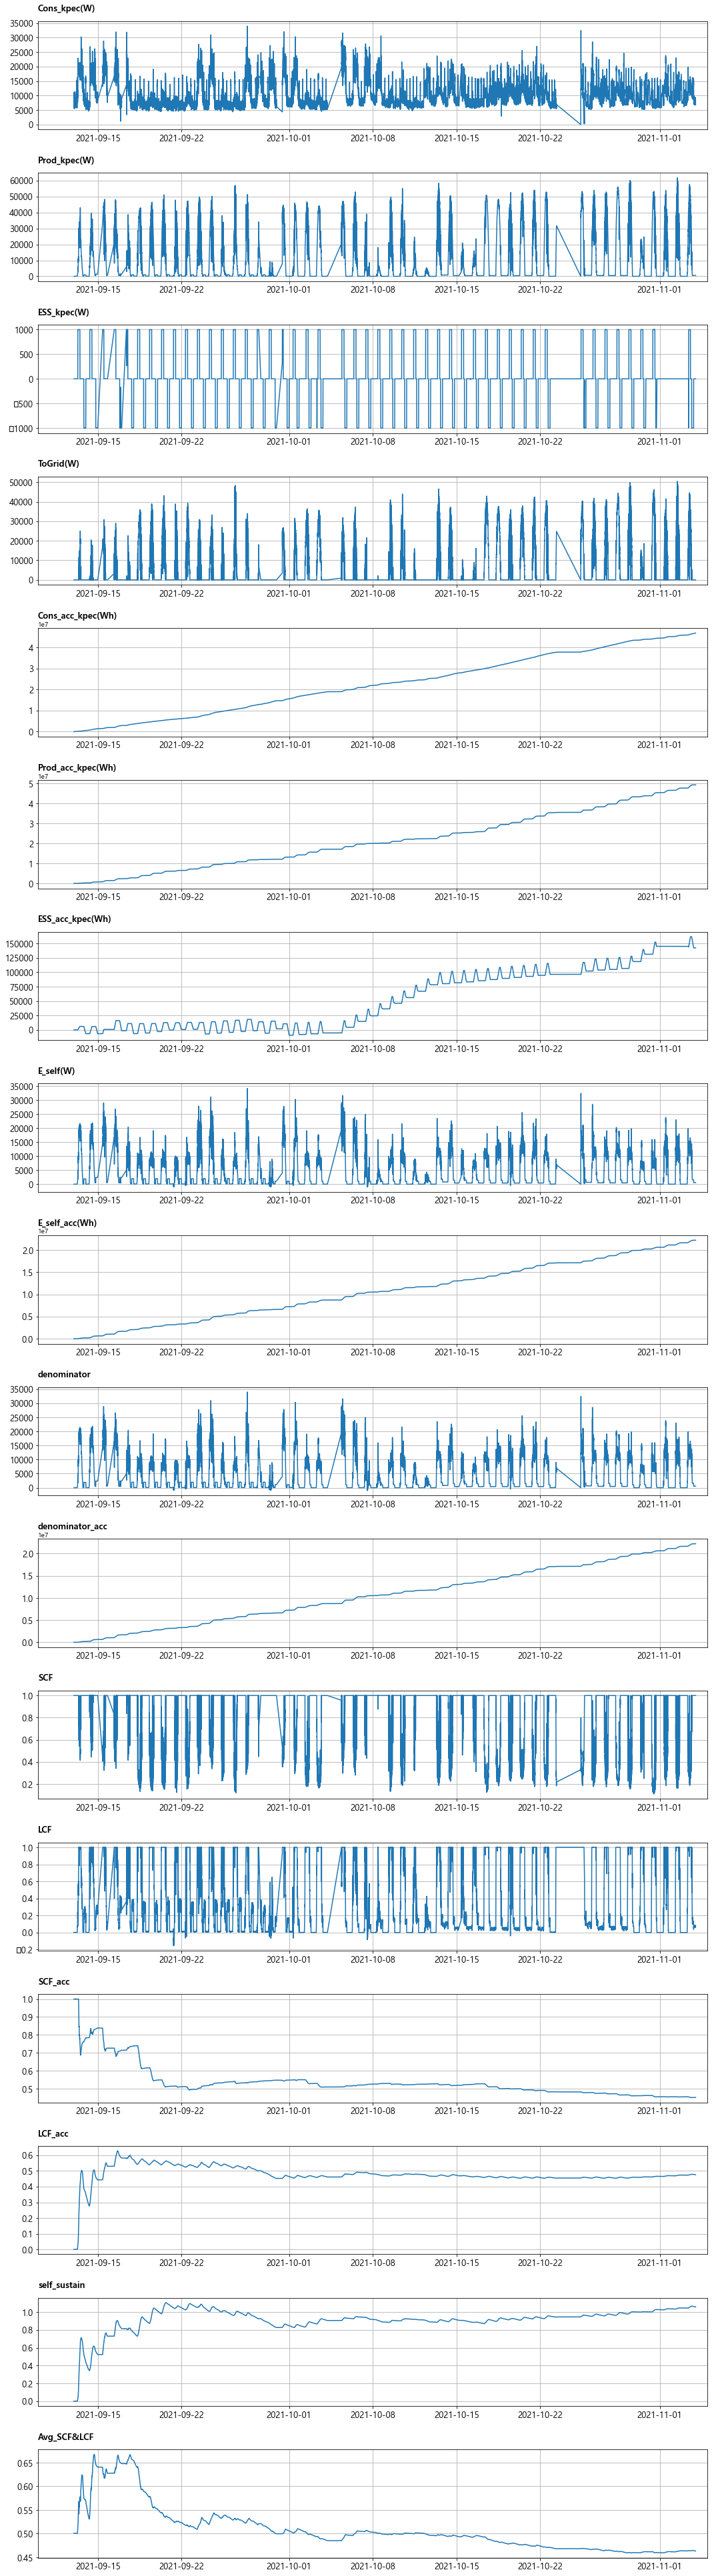

In [35]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    plt.plot(df_kpec[name])    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [36]:
df = pd.read_csv('./211105_kpec_tot_ver4.csv', parse_dates = True)

In [37]:
df

,Time,Cons_kpec(W),Prod_kpec(W),ESS_kpec(W),ToGrid(W),Cons_acc_kpec(Wh),Prod_acc_kpec(Wh),ESS_acc_kpec(Wh),E_self(W),E_self_acc(Wh),denominator,denominator_acc,SCF,LCF,SCF_acc,LCF_acc,self_sustain,Avg_SCF&LCF
0,2021-09-13 00:06:00,5711.75,9.667,-0.0,0.0,4.759792e+02,8.055833e-01,-0.00000,9.667,8.055833e-01,9.667,8.055833e-01,1.0,0.001692,1.000000,0.001692,0.001692,0.500846
1,2021-09-13 00:08:00,6590.12,9.766,-0.0,0.0,1.025156e+03,1.619417e+00,-0.00000,9.766,1.619417e+00,9.766,1.619417e+00,1.0,0.001482,1.000000,0.001580,0.001580,0.500790
2,2021-09-13 00:15:00,8104.46,9.560,-0.0,0.0,1.700527e+03,2.416083e+00,-0.00000,9.560,2.416083e+00,9.560,2.416083e+00,1.0,0.001180,1.000000,0.001421,0.001421,0.500710
3,2021-09-13 00:18:00,7236.15,9.379,-0.0,0.0,2.303540e+03,3.197667e+00,-0.00000,9.379,3.197667e+00,9.379,3.197667e+00,1.0,0.001296,1.000000,0.001388,0.001388,0.500694
4,2021-09-13 00:19:00,8711.00,9.200,-0.0,0.0,3.029457e+03,3.964333e+00,-0.00000,9.200,3.964333e+00,9.200,3.964333e+00,1.0,0.001056,1.000000,0.001309,0.001309,0.500654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53811,2021-11-03 23:55:00,7573.30,569.283,-0.0,0.0,4.673096e+07,4.939746e+07,142230.88975,569.283,2.222315e+07,569.283,2.222315e+07,1.0,0.075170,0.451183,0.475555,1.057061,0.463369
53812,2021-11-03 23:56:00,7719.92,567.933,-0.0,0.0,4.673161e+07,4.939751e+07,142230.88975,567.933,2.222319e+07,567.933,2.222319e+07,1.0,0.073567,0.451184,0.475549,1.057047,0.463367
53813,2021-11-03 23:57:00,7962.67,567.933,-0.0,0.0,4.673227e+07,4.939756e+07,142230.88975,567.933,2.222324e+07,567.933,2.222324e+07,1.0,0.071324,0.451184,0.475544,1.057033,0.463364
53814,2021-11-03 23:58:00,8019.32,569.500,-0.0,0.0,4.673294e+07,4.939761e+07,142230.88975,569.500,2.222329e+07,569.500,2.222329e+07,1.0,0.071016,0.451185,0.475538,1.057019,0.463361


In [38]:
df['Time']= pd.to_datetime(df['Time'])

C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\User\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


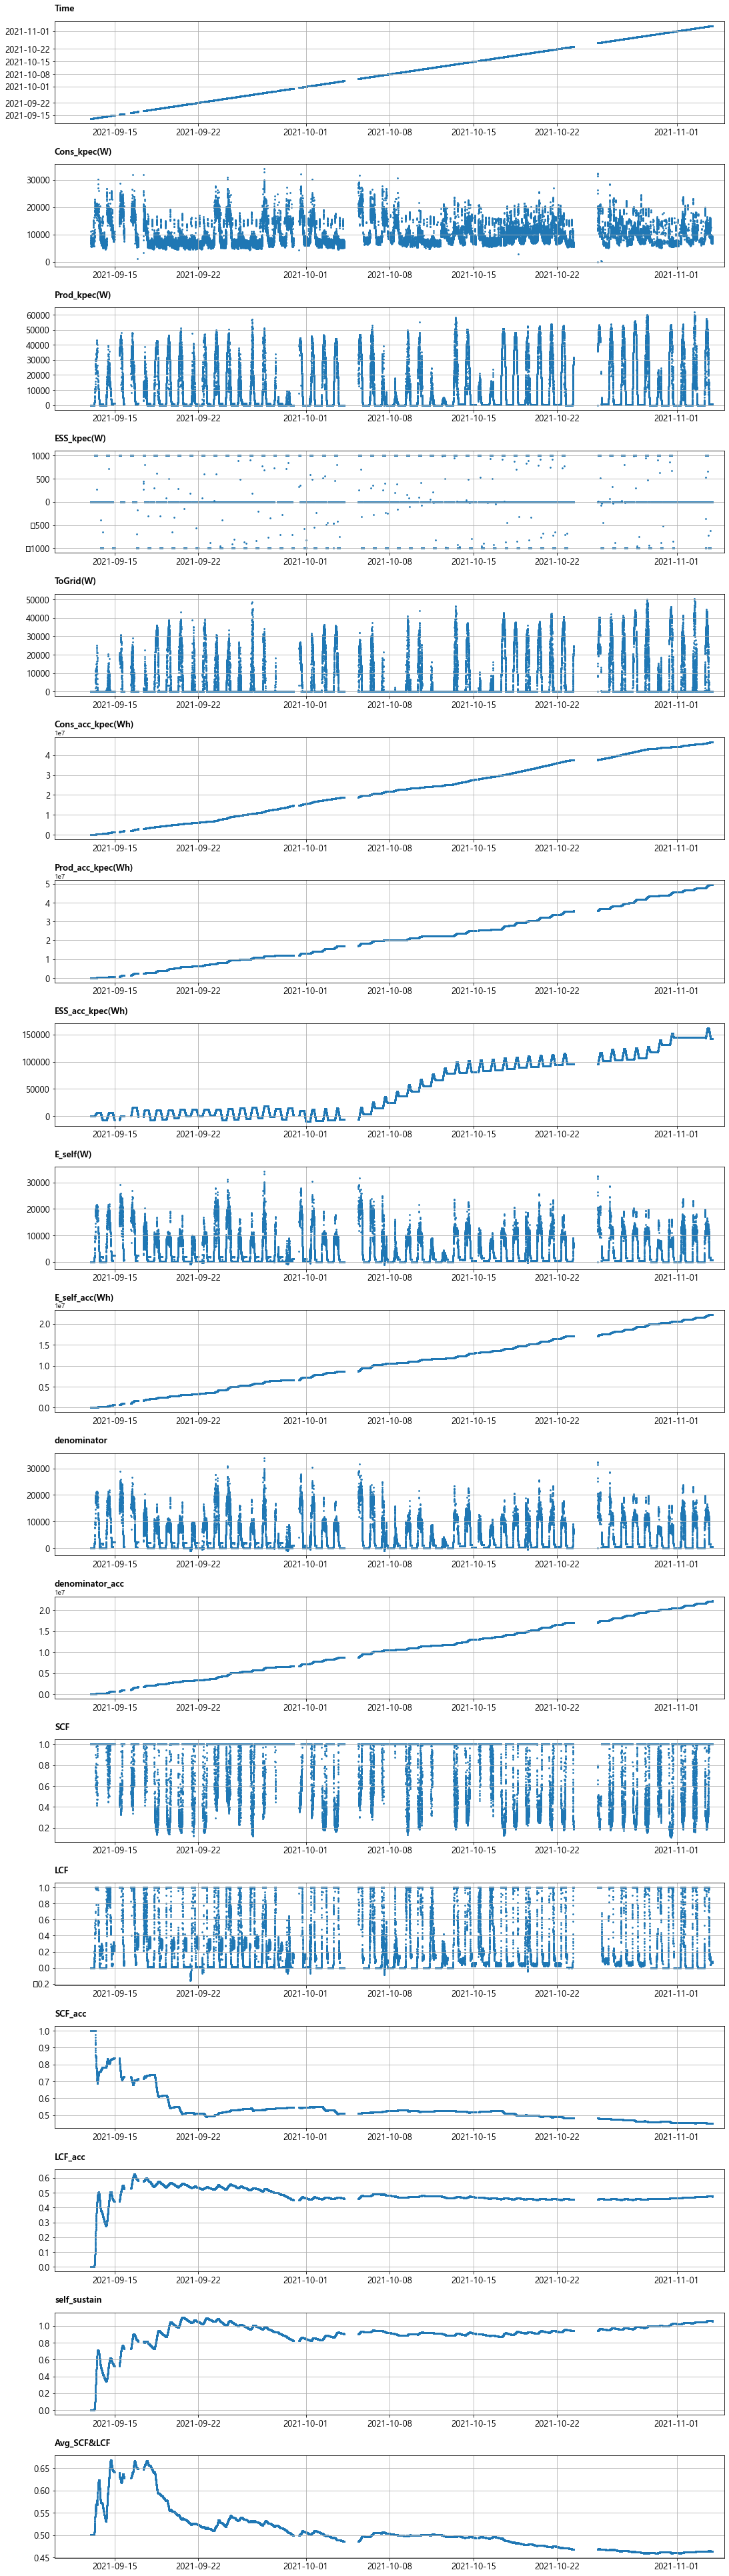

In [40]:
fig, ax = plt.subplots(figsize=(18,70))


for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.xlim(pd.Timestamp('2021-09-10'), pd.Timestamp('2021-11-05'))    
    name = df.columns[i]
    plt.scatter(x=df['Time'], y=df[name], s=3)   
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)    
    plt.grid(True)
plt.show()
fig.tight_layout()